In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import functools as ft
import itertools as it
import math
import operator as op
import os

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc, signal
from sklearn import metrics as skmetrics

from paprotka.classifier import dtw, markov
from paprotka.dataset import reddots
from paprotka.feature import cepstral
import paprotka.io as pio
from paprotka.jupyter import *

In [3]:
enrollments = reddots.load_enrollments('../input/reddots_r2015q4_v1/ndx/f_part_01.trn', 
                                       '../input/reddots_r2015q4_v1/ndx/m_part_01.trn')
trials = reddots.load_trials('../input/reddots_r2015q4_v1/ndx/f_part_01.ndx', 
                             '../input/reddots_r2015q4_v1/ndx/m_part_01.ndx')
load_pcm = ft.partial(reddots.load_pcm, '../input/reddots_r2015q4_v1/pcm')

In [4]:
correct_trials = reddots.filter_correct_speaker(reddots.filter_correct_sentence(trials))
sentence_groups = reddots.group_same_sentence(enrollments, correct_trials)

In [5]:
def show_enrollments(enrollments):
    def show_enrollment(index):
        person, pcm_triple = (col[index] for col in enrollments)
        print(person)
        print(pcm_triple)
        for pcm_path in pcm_triple:
            pcm = load_pcm(pcm_path)
            pio.play_sound(pcm)

    interact_manual(
        show_enrollment, 
        index=(0, len(enrollments[0]) - 1)
    );
show_enrollments(sentence_groups[31][0])

In [6]:
def show_trials(trials):
    def show_trial(index):
        person, pcm_path, truth_row = (col[index] for col in trials)
        print(person)
        print(pcm_path)
        print(truth_row)
        pcm = load_pcm(pcm_path)
        pio.play_sound(pcm)

    interact_manual(
        show_trial, 
        index=(0, len(trials[0]) - 1)
    );
show_trials(sentence_groups[31][1])

In [39]:
def show_samples(trials):
    def show_sample(index):
        person, pcm_path, truth_row = (col[index] for col in trials)
        sound = load_pcm(pcm_path)
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
        display_sound(sound, root=ax1, show=False)
        display_spectrogram(sound, root=ax2, nperseg=512, noverlap=256)
    interact(
        show_sample, 
        index=(0, len(trials[0]) - 1)
    );
    
show_samples(sentence_groups[31][1])

In [83]:
def show_samples(trials):
    def show_sample(index1, index2):
        sound1 = load_pcm(trials[1][index1])
        sound2 = load_pcm(trials[1][index2])
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
        display_spectrogram(sound1, root=ax1, show=False, nperseg=512, noverlap=256)
        display_spectrogram(sound2, root=ax2, nperseg=512, noverlap=256)
        
        result1 = cepstral.calculate_mfcc(sound1)
        result2 = cepstral.calculate_mfcc(sound2)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
        ax1.pcolormesh(result1.T)
        ax2.pcolormesh(result2.T)
        plt.show()
    interact(
        show_sample, 
        index1=(0, len(trials[0]) - 1),
        index2=(0, len(trials[0]) - 1)
    );
    
show_samples(sentence_groups[31][1])

Great description of mel frequency cepstral coefficients is [here](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html).

MFCC - dct has whitening effect, good for GMM-HMM. DCT is a linear transformation, discards some nonlinear information. Filter Banks became popular along with neural networks, which don't need uncorrelated data and can learn the discarded dependencies.

[ 35  43  50  60  72  86 103 123 146 174]


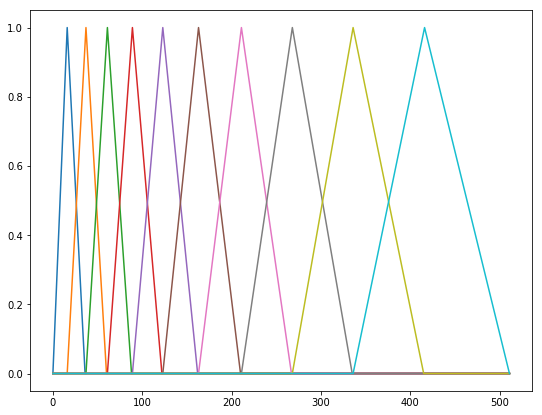

In [43]:
filters = cepstral.make_mel_filters(512, 8000, filter_num=10)
print((filters != 0).sum(axis=1))

fig, ax = plt.subplots(figsize=(9, 7))
for row in filters:
    ax.plot(row)
plt.show()

In [49]:
def show_cepstrums(trials):
    def show_cepstrum(index):
        person, pcm_path, truth_row = (col[index] for col in trials)
        sound = load_pcm(pcm_path)
        result0 = cepstral.calculate_filter_bank(sound)
        result1 = cepstral.calculate_mfcc(sound) #, num_ceps=None)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        display_covariance(result0.T, root=ax1, show=False)
        display_covariance(result1.T, root=ax2)
        
        cov0 = np.abs(np.corrcoef(result0.T))
        np.fill_diagonal(cov0, 0)
        print(cov0.mean(), cov0.min(), cov0.max(), cov0.std())
        plt.pcolormesh(result0.T)
        plt.show()
        
        cov1 = np.abs(np.corrcoef(result1.T))
        np.fill_diagonal(cov1, 0)
        print(cov1.mean(), cov1.min(), cov1.max(), cov1.std())
        plt.pcolormesh(result1.T)
        plt.show()
    interact(
        show_cepstrum, 
        index=(0, len(trials[0]) - 1)
    );
    
show_cepstrums(sentence_groups[31][1])

In [34]:
def transform_trial_features(trials):
    features = []
    labels = []
    for person, pcm_path, truth_row in zip(*trials):
        label = person.split('_', 1)[0]
        sound = load_pcm(pcm_path)
        feature_vector = cepstral.calculate_mfcc(sound)
        features.append(feature_vector)
        labels.append(label)
    return features, np.array(labels)

def transform_enrollment_features(enrollments):
    features = []
    labels = []
    for person, pcm_triple in zip(*enrollments):
        label = person.split('_', 1)[0]
        for pcm_path in pcm_triple:
            sound = load_pcm(pcm_path)
            feature_vector = cepstral.calculate_mfcc(sound)
            features.append(feature_vector)
            labels.append(label)
    return features, np.array(labels)

def transform_sentence_group(group):
    enrollments, trials = group
    transformed_enrollments = transform_enrollment_features(enrollments)
    transformed_trials = transform_trial_features(trials)
    return transformed_enrollments, transformed_trials

transformed_groups = {
    key: transform_sentence_group(group) for key, group in sentence_groups.items()
}

In [63]:
dtw.calculate_dtw(lambda a, b: 0 if a == b else 1, "ABBXCYC", "ABC")

<tr> <td>0.0</td><td>inf</td><td>inf</td><td>inf</td><td>inf</td><td>inf</td><td>inf</td><td>inf</td> </tr>
<tr> <td>inf</td><td>0.0</td><td>1.0</td><td>2.0</td><td>3.0</td><td>4.0</td><td>5.0</td><td>6.0</td> </tr>
<tr> <td>inf</td><td>1.0</td><td>0.0</td><td>0.0</td><td>1.0</td><td>2.0</td><td>3.0</td><td>4.0</td> </tr>
<tr> <td>inf</td><td>2.0</td><td>1.0</td><td>1.0</td><td>1.0</td><td>1.0</td><td>2.0</td><td>2.0</td> </tr>


2.0

In [74]:
def classify_dtw(task):
    (e_features, e_labels), (t_features, t_labels) = task
    print(len(e_features), len(t_features))
    classifier = dtw.DynamicTimeWarpingClassifier()
    classifier.fit(e_features, e_labels)
    return classifier.predict(t_features)

dtw_predictions = classify_dtw(transformed_groups[31])

114 390


In [64]:
def classify_markov(task):
    (e_features, e_labels), (t_features, t_labels) = task
    print(len(e_features), len(t_features))
    classifier = markov.HMMGMMClassifier()
    classifier.fit(e_features, e_labels, n_components=10, n_mix=2)
    return classifier.predict(t_features)

markov_predictions = classify_markov(transformed_groups[31])

114 390


In [72]:
def measure_results(t_predictions, t_labels):
    report = metrics.classification_report(t_labels, t_predictions)
    print(report)
    
#     display_confusion(t_prediction, t_labels)
    fig, ax = plt.subplots(figsize=(7, 7))
    unique_labels = np.unique(np.vstack((t_labels, t_predictions)))
    matrix = metrics.confusion_matrix(t_labels, t_predictions, unique_labels)
    print(matrix)
    img = plt.imshow(matrix, interpolation='nearest')
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.set_yticks(range(len(unique_labels)))
    ax.set_yticklabels(unique_labels)
    ax.set_xticks(range(len(unique_labels)))
    ax.set_xticklabels(unique_labels, rotation='vertical')
    plt.show()

             precision    recall  f1-score   support

      f0002       1.00      0.95      0.97        20
      f0004       1.00      0.67      0.80         6
      f0005       1.00      0.44      0.62         9
      f0006       0.44      1.00      0.62        12
      f0008       1.00      0.92      0.96        13
      f0012       1.00      1.00      1.00         6
      m0001       0.90      0.93      0.91        28
      m0002       0.38      1.00      0.55        26
      m0004       1.00      1.00      1.00         3
      m0005       0.90      1.00      0.95         9
      m0006       0.90      1.00      0.95         9
      m0007       1.00      0.40      0.57        15
      m0009       0.82      0.70      0.76        20
      m0013       1.00      0.95      0.97        19
      m0014       1.00      0.20      0.33        10
      m0015       1.00      0.36      0.53        14
      m0016       0.25      0.40      0.31         5
      m0017       0.62      0.56      0.59   

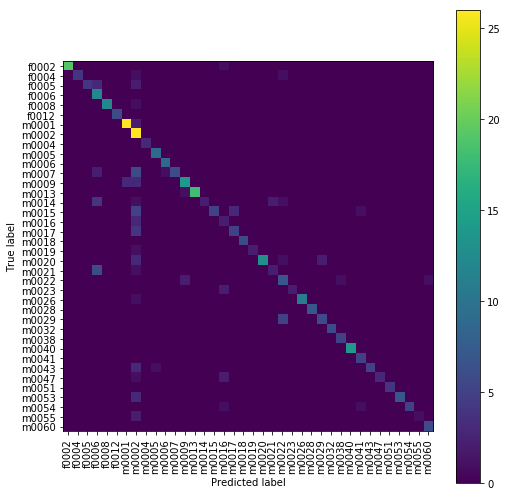

In [76]:
measure_results(dtw_predictions, transformed_groups[31][1][1])

             precision    recall  f1-score   support

      f0002       0.94      0.75      0.83        20
      f0004       0.00      0.00      0.00         6
      f0005       0.62      0.89      0.73         9
      f0006       0.50      0.58      0.54        12
      f0008       0.89      0.62      0.73        13
      f0012       1.00      1.00      1.00         6
      m0001       0.95      0.64      0.77        28
      m0002       0.91      0.81      0.86        26
      m0004       0.10      1.00      0.18         3
      m0005       1.00      0.33      0.50         9
      m0006       0.62      0.56      0.59         9
      m0007       0.88      0.47      0.61        15
      m0009       1.00      0.05      0.10        20
      m0013       1.00      0.26      0.42        19
      m0014       0.00      0.00      0.00        10
      m0015       0.75      0.43      0.55        14
      m0016       0.25      0.60      0.35         5
      m0017       0.38      0.67      0.48   

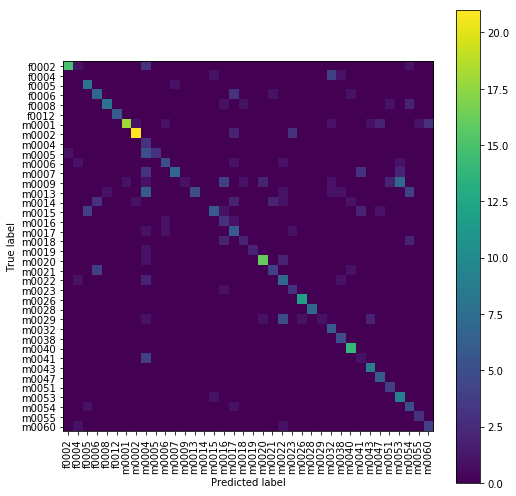

In [73]:
measure_results(markov_predictions, transformed_groups[31][1][1])

In [10]:
def markov_fun():
    # deszczowo, pochmurnie, słonecznie

    a = np.array([[0.4, 0.3, 0.3], 
                  [0.2, 0.6, 0.2], 
                  [0.1, 0.1, 0.8]])

    # zimno, ciepło

    b = np.array([[0.7, 0.3],
                  [0.5, 0.5],
                  [0.8, 0.2]])


    b_dupe = np.eye(3)


    states = np.array([2, 1, 1, 2, 0], dtype=np.int32)

    print(markov.states_probability(a, states))

    observations = np.array([0, 1, 1, 0], dtype=np.int32)

    print(markov.forward_algorithm(a, b, observations))
    
markov_fun()

0.0012
0.0454526666667
